## Importing file

In [5]:
import h5py
import helpers
import numpy as np
from pathlib import Path
import torch
from torch.utils import data

class HDF5Dataset(data.Dataset):
    """Represents an abstract HDF5 dataset.
    
    Input params:
        file_path: Path to the folder containing the dataset (one or multiple HDF5 files).
        recursive: If True, searches for h5 files in subdirectories.
        load_data: If True, loads all the data immediately into RAM. Use this if
            the dataset is fits into memory. Otherwise, leave this at false and 
            the data will load lazily.
        data_cache_size: Number of HDF5 files that can be cached in the cache (default=3).
        transform: PyTorch transform to apply to every data instance (default=None).
    """
    def __init__(self, file_path, recursive, load_data, data_cache_size=3, transform=None):
        super().__init__()
        self.data_info = []
        self.data_cache = {}
        self.data_cache_size = data_cache_size
        self.transform = transform

        # Search for all h5 files
        p = Path(file_path)
        assert(p.is_dir())
        if recursive:
            files = sorted(p.glob('**/*.h5'))
        else:
            files = sorted(p.glob('*.h5'))
        if len(files) < 1:
            raise RuntimeError('No hdf5 datasets found')

        for h5dataset_fp in files:
            self._add_data_infos(str(h5dataset_fp.resolve()), load_data)
            
    def __getitem__(self, index):
        # get data
        x = self.get_data("data", index)
        if self.transform:
            x = self.transform(x)
        else:
            x = torch.from_numpy(x)

        # get label
        y = self.get_data("label", index)
        y = torch.from_numpy(y)
        return (x, y)

    def __len__(self):
        return len(self.get_data_infos('data'))
    
    def _add_data_infos(self, file_path, load_data):
        with h5py.File(file_path) as h5_file:
            # Walk through all groups, extracting datasets
            for gname, group in h5_file.items():
                for dname, ds in group.items():
                    # if data is not loaded its cache index is -1
                    idx = -1
                    if load_data:
                        # add data to the data cache
                        idx = self._add_to_cache(ds.value, file_path)
                    
                    # type is derived from the name of the dataset; we expect the dataset
                    # name to have a name such as 'data' or 'label' to identify its type
                    # we also store the shape of the data in case we need it
                    self.data_info.append({'file_path': file_path, 'type': dname, 'shape': ds.value.shape, 'cache_idx': idx})

    def _load_data(self, file_path):
        """Load data to the cache given the file
        path and update the cache index in the
        data_info structure.
        """
        with h5py.File(file_path) as h5_file:
            for gname, group in h5_file.items():
                for dname, ds in group.items():
                    # add data to the data cache and retrieve
                    # the cache index
                    idx = self._add_to_cache(ds.value, file_path)

                    # find the beginning index of the hdf5 file we are looking for
                    file_idx = next(i for i,v in enumerate(self.data_info) if v['file_path'] == file_path)

                    # the data info should have the same index since we loaded it in the same way
                    self.data_info[file_idx + idx]['cache_idx'] = idx

        # remove an element from data cache if size was exceeded
        if len(self.data_cache) > self.data_cache_size:
            # remove one item from the cache at random
            removal_keys = list(self.data_cache)
            removal_keys.remove(file_path)
            self.data_cache.pop(removal_keys[0])
            # remove invalid cache_idx
            self.data_info = [{'file_path': di['file_path'], 'type': di['type'], 'shape': di['shape'], 'cache_idx': -1} if di['file_path'] == removal_keys[0] else di for di in self.data_info]

    def _add_to_cache(self, data, file_path):
        """Adds data to the cache and returns its index. There is one cache
        list for every file_path, containing all datasets in that file.
        """
        if file_path not in self.data_cache:
            self.data_cache[file_path] = [data]
        else:
            self.data_cache[file_path].append(data)
        return len(self.data_cache[file_path]) - 1

    def get_data_infos(self, type):
        """Get data infos belonging to a certain type of data.
        """
        data_info_type = [di for di in self.data_info if di['type'] == type]
        return data_info_type

    def get_data(self, type, i):
        """Call this function anytime you want to access a chunk of data from the
            dataset. This will make sure that the data is loaded in case it is
            not part of the data cache.
        """
        fp = self.get_data_infos(type)[i]['file_path']
        if fp not in self.data_cache:
            self._load_data(fp)
        
        # get new cache_idx assigned by _load_data_info
        cache_idx = self.get_data_infos(type)[i]['cache_idx']
        return self.data_cache[fp][cache_idx]
    


ModuleNotFoundError: No module named 'helpers'

## Basic Saving and Reading Data

In [19]:
import h5py
import numpy as np

arr = np.random.randn(1000)

with h5py.File('data_output/random.hdf5', 'w') as f:
    dset = f.create_dataset("default", data=arr)

In [20]:
with h5py.File('data_output/random.hdf5', 'r') as f:
    data = f['default']
    print(min(data))
    print(max(data))
    print(data[:15])

-3.0689173071586406
3.5945494361893866
[ 0.1707707   1.06729959  1.62013985 -0.78875181 -0.91574721  0.62563722
  0.168924   -0.59915426  0.94944956 -0.02310949 -0.30186686 -1.11995526
 -0.99511676 -2.57044898 -0.22483986]


In [21]:
with h5py.File('data_output/random.hdf5', 'r') as f:
    data = f['default']
    for key in f.keys():
        print(key)

default


In [26]:
# mean to produce ValueError
f = h5py.File('data_output/random.hdf5', 'r')
data = f['default']
f.close()
print(data)
print(data[1])

<Closed HDF5 dataset>


ValueError: Not a dataset (not a dataset)

In [23]:
f = h5py.File('data_output/random.hdf5', 'r')
data = f['default'][()]
f.close()
print(data[10])

-0.3018668577023117


## Selective Reading

In [24]:
with h5py.File('data_output/random.hdf5', 'r') as f:
    data_set = f['default']
    data = data_set[:10]

print(data[1]) # won't give an error
print(data_set[1]) # will give an error

1.067299586966938


ValueError: Not a dataset (not a dataset)

In [25]:
import h5py
import numpy as np

arr1 = np.random.randn(10000)
arr2 = np.random.randn(10000)

with h5py.File('data_output/complex_read.hdf5', 'w') as f:
    f.create_dataset('array_1', data=arr1)
    f.create_dataset('array_2', data=arr2)

## Using data

In [13]:
import pandas as pd
read_Data = pd.read_hdf('data/NEONDSTowerTemperatureData.hdf5', '/Domain_03/OSBS/min_1/boom_1/temperature')
print(read_Data)

                       date  numPts       mean        min        max  \
0     2014-04-01 00:00:00.0      60  15.061538  14.968861  15.156247   
1     2014-04-01 00:01:00.0      60  14.998578  14.937197  15.042743   
2     2014-04-01 00:02:00.0      60  15.262313  15.035021  15.566826   
3     2014-04-01 00:03:00.0      60  15.453514  15.385535  15.534492   
4     2014-04-01 00:04:00.0      60  15.353062  15.237991  15.423458   
...                     ...     ...        ...        ...        ...   
4318  2014-04-03 23:56:00.0      60  23.898344  23.871227  23.970805   
4319  2014-04-03 23:57:00.0      60  23.750827  23.663440  23.865114   
4320  2014-04-03 23:58:00.0      60  23.586269  23.550309  23.660753   
4321  2014-04-03 23:59:00.0      60  23.654457  23.574530  23.699574   
4322  2014-04-04 00:00:00.0      60  23.664649  23.588757  23.758249   

      variance    stdErr  uncertainty  
0     0.002655  0.006652     0.016203  
1     0.001254  0.004572     0.013061  
2     0.041438 

In [6]:
read_Data = h5py.File('data/NEONDSTowerTemperatureData.hdf5', 'r')
list(read_Data.keys())

['Domain_03', 'Domain_10']

In [8]:
list(read_Data['Domain_03'].keys())

['OSBS']

In [9]:
list(read_Data['Domain_03']['OSBS'].keys())

['min_1', 'min_30']

In [10]:
list(read_Data['Domain_03']['OSBS']['min_1'].keys())

['boom_1', 'boom_2', 'boom_3', 'boom_5', 'tower_top']

In [11]:
list(read_Data['Domain_03']['OSBS']['min_1']['boom_1'].keys())

['temperature']

In [12]:
list(read_Data['Domain_03']['OSBS']['min_1']['boom_1']['temperature'].keys())

AttributeError: 'Dataset' object has no attribute 'keys'

In [14]:
plot_data = pd.read_hdf('data/NEONDSTowerTemperatureData.hdf5', '/Domain_03/OSBS/min_1/boom_1/temperature')

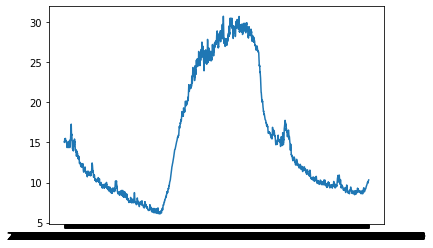

In [19]:
import matplotlib.pyplot as plt

timeList1 = list(plot_data.date)
timeList2 = timeList1[0:int(len(timeList1)/2)]

meanList1 = list(plot_data['mean'])  #can't use plot_data.mean, finds the mean of the entirity, not the column
meanList2 = meanList1[0:int(len(timeList1)/2)]

fig = plt.figure()
plt.plot(timeList2, meanList2)
plt.show()